In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tiktoken cohere
!pip install openai==1.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 75.7 MB/s eta 0:00:00
  Attempting uninstall: importlib_metadata
    Found existing installation: importlib-metadata 7.0.1
    Uninstalling importlib-metadata-7.0.1:
      Successfully uninstalled importlib-metadata-7.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires openai, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.9 MB/s eta 0:00:00


In [ ]:
# @title Eliminate wrong formatted rows
import re
import csv

# Girdi dosyasının adını ve çıktı dosyasının adını belirtin
girdi_dosyasi = 'NETFLIX_REVIEWS.csv'
cikti_dosyasi = 'cikti.csv'

# Regex deseni tanımlayın
desen = re.compile(r'.*?,\".*?\",\".*?\",\".*?\",\".*?\".*?,\".*?\",\".*?\"')

# Girdi dosyasını açın ve çıktı dosyasını hazırlayın
with open(girdi_dosyasi, 'r') as girdi, open(cikti_dosyasi, 'w') as cikti:
    for satir in girdi:
        if desen.match(satir):
            cikti.write(satir)


In [ ]:
#@title N
import json

# JSON verisini dosyadan oku
with open("finetuna.json", "r") as dosya:
    verilen_json = json.load(dosya)

# Yeni JSONL verisi oluşturmak için kullanılacak liste
jsonl_verisi = []

# Her objeyi işleyin ve yeni formatı oluşturun
for obje in verilen_json:
    user_content = obje["Review input"]
    assistant_content = json.dumps({k: v for k, v in obje.items() if k != "Review input"})

    yeni_obje = {
        "messages": [
            {"role": "user", "content": user_content},
            {"role": "assistant", "content": assistant_content}
        ]
    }

    jsonl_verisi.append(json.dumps(yeni_obje))

# JSONL verisini dosyaya yaz
with open("output.jsonl", "w") as dosya:
    for jsonl in jsonl_verisi:
        dosya.write(jsonl + "\n")

In [ ]:
#@title M
import json

def process_messages(input_file, output_file):
    # Girdi JSON dosyasını okuma
    with open(input_file, 'r', encoding='utf-8') as f:
        input_data = json.load(f)

    # Çıktı oluşturma
    jsonl_verisi = []

    for index in range(0, len(input_data), 3):
        # Her üç mesajı gruplayıp indekslerini id olarak ekleme
        grouped_messages = {"count": 3, "messages": []}

        for i in range(3):
            entry = input_data[index + i]
            grouped_messages["messages"].append({"id": i + 1, "content": entry["Review input"]})

        user_content = json.dumps(grouped_messages)

        # Sentiment değerlerini mevcut değerlerle ekleme
        sentiment_results = [{"id": i+1, "sentiment": {key: entry[key] for key in entry.keys() if key != "Review input"}} for i, entry in enumerate(input_data[index:index+3])]

        assistant_content = json.dumps({"count": 3, "sentimentResults": sentiment_results})

        yeni_obje = {
            "messages": [
                {"role": "user", "content": user_content},
                {"role": "assistant", "content": assistant_content}
            ]
        }

        jsonl_verisi.append(json.dumps(yeni_obje))

        # JSONL verisini dosyaya yaz
        with open("output.jsonl", "w") as dosya:
            for jsonl in jsonl_verisi:
                dosya.write(jsonl + "\n")

# Kullanım örneği
input_file_path = 'finetuna.json'  # Girdi dosyasının adını ve yolunu belirtin
output_file_path = 'cikti.jsonl'  # Çıktı dosyasının adını ve yolunu belirtin
process_messages(input_file_path, output_file_path)









###OpenAI

In [ ]:
# @title OpenAI initialization
from openai import OpenAI
client = OpenAI(api_key="<OPENAI_API_KEY>")

###Finetuning

In [ ]:
# @title Retrive Fine Tune Job
response = client.fine_tuning.jobs.retrieve("ftjob-<FINE_TUNE_JOB_ID>")
response2 = client.fine_tuning.jobs.retrieve("ftjob-<FINE_TUNE_JOB_ID>")
fine_tuned_model_id = response.fine_tuned_model
fine_tuned_model_id2 = response2.fine_tuned_model
print("\nFine-tuned model id:", fine_tuned_model_id)
print("\nFine-tuned model id2:", fine_tuned_model_id2)


Fine-tuned model id: ft:gpt-3.5-turbo-1106:personal::8i8a6GDi

Fine-tuned model id2: ft:gpt-3.5-turbo-0613:personal::8jN2f6OM


In [ ]:
from os import defpath
# @title Preprocesssing
import pandas as pd
import csv
import time
import json
import re

def preprocess(input_string):
  compressed = compress_repeated_characters(input_string)
  without_emojis = remove_emojis(compressed)
  return without_emojis

def compress_repeated_characters(input_string, min_repeats=5):
    new_string = ""
    repeat_count = 1

    for i in range(1, len(input_string)):
        if input_string[i] == input_string[i - 1]:
            repeat_count += 1
        else:
            if repeat_count >= min_repeats:
                new_string += input_string[i - 1]
            else:
                new_string += input_string[i - repeat_count:i]

            repeat_count = 1

    if repeat_count >= min_repeats:
        new_string += input_string[-1]
    else:
        new_string += input_string[-repeat_count:]

    return new_string

def remove_emojis(input_string):
  regex = re.compile(u"[^\U00000000-\U0000d7ff\U0000e000-\U0000ffff]", flags=re.UNICODE)
  return re.sub(regex, '', input_string)

csvfile = '/content/drive/MyDrive/dataset.csv'
df = pd.read_csv(csvfile, encoding='utf-8')

#df['review_text']=df['review_text'].astype("string")
#df=df[(df['review_text'].dtype == str)]


# sort by timetamp
df2=df.sort_values(by=['review_timestamp'], ascending=True)


#reviews=df2[(df2['review_likes']>=1) & (df2['review_text'].str.len()>150) & (df2['review_rating'] <= 4)]

#grouped_reviews = review_1.groupby(pd.to_datetime(review_1['review_timestamp']).dt.date)

#df2["review_text"] = df2["review_text"][df2["review_text"].apply(isinstance, args=(str,))]

#reviews2 = df2.sample(frac=1, random_state=99).reset_index(drop=True).head(20)

#reviews2["review_text"] = reviews2["review_text"].map(lambda x: len(str(x)))

#with open('noop2.json', 'w') as file:
#    file.write(reviews2['review_text'].to_json(orient='records'))

#reviews2.sample(frac=1, random_state=99).reset_index(drop=True).head(100)

# remove emojis and truncate reviews containing only emojis
df2["review_text"] = df2["review_text"].map(lambda x: preprocess(str(x)))
reviews2=df2[(df2['review_text'].str.len()>0)]

# take last 1000 reviwes
#reviews3 = reviews2[-1000:]

offset=2500
#page=29

def slice_page(page):
  return reviews2[:-offset*page][-offset:]

In [ ]:
reviews2[150000:150025]

Unnamed: 0                             review_id  \
152377     1338701  415614fc-605f-4df7-af0a-7bc0490698de   
152378     1338702  fdb96798-e3f2-42e0-af11-b1043903c035   
152379     1338703  3502cefc-fb9d-48c3-8a15-516f5b3b0083   
152380     1338704  593aebc7-f781-4ade-9766-4ff61c1298a5   
152381     1338705  a8bc21bc-6536-47c1-8a83-5f4cd7db5f26   
152382     1338706  b12ffe05-4e1c-4b26-938f-80af9bd1b603   
152383     1338707  c83d9a07-6375-4b1e-9245-0614a6e15cda   
152384     1338708  c99b93e7-e891-457e-871f-ceebdd315646   
152385     1338709  d6ac335b-f8fa-4c79-8626-f8bf4bb58f05   
152386     1338710  2df6a5f1-f373-48c2-8856-7450a61bddd8   
152387     1338711  b0dd9243-ee96-447f-8135-4476400179e1   
152388     1338712  4a4d8a47-37e0-4e68-81f0-4ae769f873a7   
152390     1338714  141b16ec-35e3-472e-a602-1cd87bd66091   
152391     1338715  59ee0c57-569a-4840-a8a3-6d7421f3e2f0   
152392     1338716  7808fd2a-e394-4bad-bd24-41a3ce119944   
152393     1338717  b94ef3e6-3f3f-4de1-9bc3-8b7bb2b92a73   
152394     1338718  fdba8053-dbf0-4e9a-b007-390853e77352   
152395     1338719  038ae0dc-e09d-4441-b37a-cab2934a11ce   
152396     1338720  3a097e09-fb39-40f0-825d-b9d48ef718fa   
152397     1338721  787f4b12-f2f4-41ef-a1de-6721ff75b114   
152398     1338722  9bc96e55-3d7c-4d8f-a008-20b1cb865074   
152399     1338723  10cdc19a-a580-447c-b52c-af7839d90ba4   
152400     1338724  f2cb40f9-1eff-4ccd-bd0f-48af757771bc   
152401     1338725  f62f9fab-13bd-4a09-a14f-2c11005463ab   
152402     1338726  b37b0838-d096-4c37-80ec-3e3675fd8e3e   

             pseudo_author_id                 author_name  \
152377  200102534946352933011                 Ch*******ah   
152378  571066593511411385474               Ma*********ki   
152379  288038002431282238863               ci*********ri   
152380  231190431625840369561                Ne********an   
152381  223477980383542194233           Di*************at   
152382  128944501468040693028               Me*********mi   
152383  223277530526988476026                Fu********ka   
152384  221389370037939202898                vi********ni   
152385  280056621771170379455               Ja*********en   
152386  211364073813618376370       fu*****************ay   
152387  137334800554921859646  Ce**********************ño   
152388  104481909348451851147                    Ke**** E   
152390  290154408759020538914                Dj********hd   
152391  195481127780446238866                  ni******ve   
152392  253307200324523085049            My************de   
152393  910664160763399606853             Th***********ku   
152394  125538687071519105172                         ***   
152395  664016204942275381382                Me********ta   
152396  291816152659198798554             Me***********de   
152397  563027180438095400754               Wo*********wn   
152398  281573807761254166704             HE***********ES   
152399  181840765642094831286                Ka********ko   
152400  537830325036666219376                    Ch****ie   
152401  815064689611104466115             Gr***********ah   
152402  237941652943892023499                 Gr*******on   

                                              review_text  review_rating  \
152377  The app is really nice the experience has been...              3   
152378  Went downhill, too bad used to be good. Dumb d...              2   
152379             Very Good! Easy to do Thanks , Cynthia              5   
152380  Extremely disappointed. What kind of clowns ar...              1   
152381  Messed up my last review. The app is great, ha...              5   
152382  Thanks netfilix for sell there gift cards in t...              5   
152383  This app is super great and easy to use The pi...              5   
152384  Not worth to download anything because it will...              1   
152385                   This app always works...always.               5   
152386                                   Its fun to watch              5   
152387                  

In [ ]:
qq = """not a lot😗😝😜🤪🤨 of movies and ive pretty much watched em allnnnnnnnnnnnnnnnnnnnnnnn😙😚😋😛nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn"""
preprocess(qq)

'not a lot of movies and ive pretty much watched em allnn'

In [ ]:
# @title Sentiment analysis by chunks
import json
import threading
import openai

DEFAULT_SYSTEM_PROMPT = "Return dissatisfaction categories en each reviews as json. Dissatisfaction categories must be one of them: Content, UI/UX, Bugs/stability, Customer service, Subscription/payment, Downloading/connection. Do not return any result for a review if there is no dissatisfaction with these categories. A review can be related to multiple categories at once. You are given an reviews object which the key is id and the value is review. You must return an object which the key is id and the value is string array. Each review should be analyzed independently of the other."

def predict_with_llm(message, model):
    message_formatted = [{"role": "system", "content": DEFAULT_SYSTEM_PROMPT},{"role": "user", "content": message}]
    response = client.chat.completions.create(model=model, messages = message_formatted)
    return response.choices[0].message.content

listt = []

def res(reviews_chunk, model = fine_tuned_model_id):
    # Alt döngüde parçalanan veriyi kullanarak cevap al

    x = {}
    for i, review in reviews_chunk.iterrows():
        x[i] = review["review_text"]

    input = re.sub(r':\{(.*?)\}', r'\1:', json.dumps(x))
    try:
      yy = predict_with_llm(input, model)
      yy2 = yy
      yy = re.sub(r':\{(.*?)\}', r':[\1]', yy)
      try:
        result = json.loads(re.sub(r'(\d+):', r'"\1":', yy))
        result2 = []
        for id, message in reviews_chunk.iterrows():
            r = []
            if(str(id) not in result):
              #print(f"Key {id} is not in result object!")
              pass
            else:
              r = result[str(id)]
            formatted = {"id": int(id), "timestamp": message["review_timestamp"], "review": message["review_text"], "result": r}
            result2.append(formatted)
        listt.extend(result2)
      except json.decoder.JSONDecodeError:
        print(f"json.decoder.JSONDecodeError occurred for given output: {yy2} - {yy}")
    except openai.BadRequestError:
        print(f"openai.BadRequestError occurred for given input: {input}")


def analize_reviews(reviews, output_file_name, model = fine_tuned_model_id):
  global listt
  listt = []

  threads = []

  chunk_limit = 25

  # Veriyi 25'er parçalara ayırarak alt döngü oluştur
  for start_index in range(0, len(reviews['review_text']), chunk_limit):
      end_index = start_index + chunk_limit
      reviews_chunk = reviews[start_index:end_index]
      thread = threading.Thread(target=res, args=(reviews_chunk, model))
      threads.append(thread)
      thread.start()

  for thread in threads:
      thread.join()

  # result_list'i id'ye göre sıralayın
  sorted_result = sorted(listt, key=lambda x: x['id'])

  with open(f'/content/drive/MyDrive/{output_file_name}.json', 'w') as file:
      json.dump(sorted_result, file)

def analize_page(page, model = fine_tuned_model_id):
  reviews = slice_page(page)
  analize_reviews(reviews, f'{offset*page}-{offset*(page+1)}', model)


In [ ]:
#@title Scheduler
from datetime import datetime

sleeptime = 65

page_from = 101
page_to = 101

for page in range(page_from, page_to+1):
  analize_page(page)
  print(f"Page {page} finished!")
  if(page < page_to):
    time.sleep(sleeptime)

Page 101 finished!


In [ ]:
#@title Tester
import pandas as pd

# DataFrame oluştur
reviews_actual_for_test = pd.read_csv(f'/content/drive/MyDrive/reviews_test_2.csv')

reviews_actual_for_test = reviews_actual_for_test.set_axis(reviews_actual_for_test['id'], copy=False)
reviews_actual_for_test.drop(columns=['id'], inplace=True)
reviews_actual_for_test['result'] = reviews_actual_for_test['result'].map(lambda x: json.loads(x.replace("'",'"')))

analize_reviews(reviews_actual_for_test, 'reviews_for_test_result_55', fine_tuned_model_id2)

reviews_actual_for_test

review_timestamp                                        review_text  \
id                                                                            
333308  20.09.2023 17:47  Poor video quality sd playback support only Pl...   
203632  24.07.2022 11:59  Ultimate app. Design Way of handling Programme...   
290679  17.04.2023 17:28  Do not falsify history, everyone knows the tru...   
335368  30.09.2023 10:41  What's wrong with netflix? Since last week, i'...   
320562  27.07.2023 14:03  Annoying click sound after i select profile. W...   
...                  ...                                                ...   
232180   9.10.2022 14:22  How can I contact Netflix with regards to my p...   
272582  13.03.2023 10:08                                     Haraam content   
143408   8.03.2022 02:26  the fact i can not uninstall this is irritatin...   
299283   3.05.2023 22:34  I've been having difficulties with the stupid ...   
342894   7.11.2023 09:41                    Cant get intouch only to update   

                                    result  
id                                          
333308            [Downloading/connection]  
203632                                  []  
290679                           [Content]  
335368                    [Bugs/stability]  
320562                             [UI/UX]  
...                                    ...  
232180  [Customer service, Bugs/stability]  
272582                           [Content]  
143408                    [Bugs/stability]  
299283                             [UI/UX]  
342894                  [Customer service]  

[130 rows x 3 columns]

In [ ]:
#@title Get test result

with open('/content/drive/MyDrive/reviews_for_test_result_1106.json', 'r', encoding='utf-8') as f:
  res = json.load(f)

reviews_predicted_for_test = pd.DataFrame(res)
reviews_predicted_for_test = reviews_predicted_for_test.set_axis(reviews_predicted_for_test['id'], copy=False)
reviews_predicted_for_test.drop(columns=['id'], inplace=True)

reviews_predicted_for_test

timestamp                                             review  \
id                                                                            
142287   5.03.2022 06:32  I can't update the app, even with mobile data ...   
143408   8.03.2022 02:26  the fact i can not uninstall this is irritatin...   
143520   8.03.2022 09:00  What happened ?? Every time I'm trying to open...   
145601  13.03.2022 22:57  Out of the blue I can only stream from my phon...   
146474  15.03.2022 03:26  All movies, web series automatically deleted s...   
...                  ...                                                ...   
338743  18.10.2023 07:51  Password sharing lock out is so dumb I travel ...   
339504  21.10.2023 23:25                    Not really alot if good movies.   
340033  24.10.2023 16:14  Had premium Netflix for 7 years and used to lo...   
340127  25.10.2023 04:22  I get a free sub from T-Mobile, it is the only...   
342894   7.11.2023 09:41                    Cant get intouch only to update   

                                        result  
id                                              
142287                [Downloading/connection]  
143408                        [Bugs/stability]  
143520                [Downloading/connection]  
145601                [Downloading/connection]  
146474      [Bugs/stability, Customer service]  
...                                        ...  
338743                  [Subscription/payment]  
339504                                      []  
340033  [Bugs/stability, Subscription/payment]  
340127                  [Subscription/payment]  
342894                      [Customer service]  

[130 rows x 3 columns]

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, hamming_loss, classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ID'leri kullanarak iki veri çerçevesini birleştir
df_combined = pd.merge(reviews_actual_for_test, reviews_predicted_for_test, on='id')

# Gerçek ve tahmin edilen kategorileri seç
real_categories = df_combined['result_x']  # .apply(lambda x: {e for l in x for e in l})
predicted_categories = df_combined['result_y']  # .apply(lambda x: {e for l in x for e in l})

mlb = MultiLabelBinarizer(classes=('Content', 'Customer service', 'Bugs/stability', 'UI/UX', 'Subscription/payment', 'Downloading/connection'))
real_categories_bin = mlb.fit_transform(real_categories)
predicted_categories_bin = mlb.transform(predicted_categories)

# Accuracy (Doğruluk) hesapla
accuracy = accuracy_score(real_categories_bin, predicted_categories_bin)
hl = hamming_loss(real_categories_bin, predicted_categories_bin)

# Diğer metrikleri ölç
report = classification_report(real_categories_bin, predicted_categories_bin, target_names=mlb.classes_)
confusion_matrices = multilabel_confusion_matrix(real_categories_bin, predicted_categories_bin, labels=range(len(mlb.classes_)))

print(f'Totol item count: {len(df_combined)}')
print(f'Average accurate count: {accuracy * len(df_combined)}')
print(f'Prediction accuracy: {accuracy}')
print(f'Hamming loss: {hl}')
print('\nClassification Report:\n', report)
print('\nConfusion Matrices:')


# Confusion matrisini hesapla
confusion_matrices = multilabel_confusion_matrix(real_categories_bin, predicted_categories_bin, labels=range(len(mlb.classes_)))

# Confusion matrislerini plot et
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 25))

for i, (matrix, class_name) in enumerate(zip(confusion_matrices, mlb.classes_)):
    row, col = divmod(i, 2)
    ax = axes[row, col]

    # Oranları hesapla
    row_sums = matrix.sum(axis=1)
    norm_matrix = matrix / row_sums[:, np.newaxis]

    sns.heatmap(norm_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Class: {class_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

#plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Totol item count: 130
Average accurate count: 95.0
Prediction accuracy: 0.7307692307692307
Hamming loss: 0.06025641025641026

Classification Report:
                         precision    recall  f1-score   support

               Content       0.82      0.61      0.70        23
      Customer service       0.75      0.86      0.80        14
        Bugs/stability       0.78      0.84      0.81        25
                 UI/UX       0.84      0.84      0.84        19
  Subscription/payment       0.94      0.76      0.84        21
Downloading/connection       0.93      0.68      0.79        19

             micro avg       0.84      0.76      0.80       121
             macro avg       0.84      0.77      0.80       121
          weighted avg       0.85      0.76      0.79       121
           samples avg       0.65      0.64      0.64       121


Confusion Matrices:


In [ ]:
#@title Merge results as CSV
import json
import csv
import os
import random

# ...
result_from = 0
result_to = 250000
step = 2500

# Tüm dosyaları oku ve listeye ekle
listtt = []
for x in range(result_to, result_from, -step):
    file_path = f'/content/drive/MyDrive/{x-step}-{x}.json'
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            res = json.load(f)
            listtt.extend(res)

# Listeyi iyice karıştır
#random.shuffle(listtt)

# CSV dosyasına yaz
csv_file_path = f'/content/drive/MyDrive/{result_from}-{result_to}_merged.csv'
with open(csv_file_path, 'w', newline='', encoding='utf-8') as csv_file:
    csv_writer = csv.writer(csv_file)
    # Varsa başlık satırını yaz
    if listtt and isinstance(listtt[0], dict):
        csv_writer.writerow(listtt[0].keys())
    # Verileri yaz
    for item in listtt:
        csv_writer.writerow(item.values())

print(f'Tüm veriler CSV olarak {csv_file_path} dosyasına yazıldı.')


Tüm veriler CSV olarak /content/drive/MyDrive/0-250000_merged.csv dosyasına yazıldı.


In [ ]:
#@title Merge results as JSON
import json
import csv
import os
import random

# ...
result_from = 0
result_to = 250000
step = 2500

# Tüm dosyaları oku ve listeye ekle
listtt = []
for x in range(result_to, result_from, -step):
    file_path = f'/content/drive/MyDrive/{x-step}-{x}.json'
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            res = json.load(f)
            listtt.extend(res)

# Listeyi iyice karıştır
#random.shuffle(listtt)

# CSV dosyasına yaz
json_file_path = f'/content/drive/MyDrive/{result_from}-{result_to}_merged.json'
with open(json_file_path, 'w') as file:
    json.dump(listtt, file)

print(f'Tüm veriler JSON olarak {csv_file_path} dosyasına yazıldı.')


Tüm veriler JSON olarak /content/drive/MyDrive/0-250000_merged.csv dosyasına yazıldı.


In [ ]:
# @title Group by day, sum and normalize
import json
import pandas as pd
from datetime import datetime
from collections.abc import Iterable

to_what = 250000

# output.json dosyasını oku
with open(f'/content/drive/MyDrive/0-{to_what}_merged.json', 'r', encoding='utf-8') as f:
    output_data = json.load(f)

# DataFrame oluştur
df = pd.DataFrame(output_data)

# 'timestamp' sütununu datetime formatına çevir
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

# 'timestamp' sütununu gün bazında grupla
grouped_data = df.groupby(df['timestamp'].dt.strftime('%Y-%W'))

list_ = []

list = type([])

total_count = 0

# Her bir gün için normalize et
for day, data_points in grouped_data:

    count = len(data_points)
    total_count += count

    times_min = data_points['timestamp'].min()
    times_max = data_points['timestamp'].max()
    times_mid = times_min+ (times_max-times_min)/2

    # Normalize et ve güncelle
    total_sentiments = {"Timestamp": times_mid.strftime('%Y-%m-%d'),"UI/UX": 0,"Bugs/stability": 0,"Content": 0,"Subscription/payment": 0,"Downloading/connection": 0,"Customer service": 0, "Any": 0,"Total item count":count}


    # Normalize et ve güncelle
    for index, data_point in data_points.iterrows():
        # Her bir key için normalize edilmiş değeri hesapla ve toplama ekle

        w = data_point["result"]

        if w is None:
          w = []

        if type(w) == float:
          w = []

        if type(w) == str:
          w = [w]

        if type(w) == list and len(w) == 1 and type(w[0]) == list:
          w = w[0]

        if type(w) == dict:
          print(w)
          #print(data_point["timestamp"])
          pass


        any = False

        for q in w:
            if q not in total_sentiments:
              #print(f"{q} is not a valid category!")
              continue
            total_sentiments[q] += 1
            any = True

        if(any):
          total_sentiments["Any"] += 1

    normalized_sentiments = {key: value if(key == "Total item count" or key == "Timestamp") else (value / count) for key, value in total_sentiments.items()}

    list_.append(normalized_sentiments)

list__ = list_#({k: (v / total_count) if(k == "Total item count") else v for k, v in x.items()} for x in list_)

result_matrix = pd.DataFrame(list__, index = [name for name,unused_df in grouped_data]).rename_axis('Date')

result_matrix.to_csv(f"/content/drive/MyDrive/0-{to_what}_result_1.csv")

result_matrix

Timestamp     UI/UX  Bugs/stability   Content  Subscription/payment  \
Date                                                                            
2021-44  2021-11-05  0.032995        0.089848  0.044162              0.030964   
2021-45  2021-11-11  0.022241        0.086865  0.035250              0.036089   
2021-46  2021-11-18  0.034809        0.100559  0.033090              0.033949   
2021-47  2021-11-25  0.028715        0.079307  0.041933              0.030538   
2021-48  2021-12-02  0.036155        0.096555  0.046363              0.043811   
...             ...       ...             ...       ...                   ...   
2023-42  2023-10-19  0.051493        0.114179  0.089552              0.091045   
2023-43  2023-10-26  0.052482        0.083688  0.071631              0.077305   
2023-44  2023-11-02  0.049546        0.086532  0.059316              0.085136   
2023-45  2023-11-09  0.033400        0.092852  0.061456              0.088176   
2023-46  2023-11-14  0.031153        0.099688  0.057632              0.071651   

         Downloading/connection  Customer service       Any  Total item count  
Date                                                                           
2021-44                0.029442          0.006091  0.221827              1970  
2021-45                0.027696          0.005036  0.196811              2383  
2021-46                0.030082          0.004297  0.222604              2327  
2021-47                0.022789          0.002735  0.197812              2194  
2021-48                0.027648          0.007656  0.240749              2351  
...                         ...               ...       ...               ...  
2023-42                0.025373          0.009701  0.341791              1340  
2023-43                0.021986          0.012057  0.288652              1410  
2023-44                0.016050          0.008374  0.280530              1433  
2023-45                0.028724          0.005344  0.284569              1497  
2023-46                0.035826          0.007788  0.281931               642  

[109 rows x 9 columns]

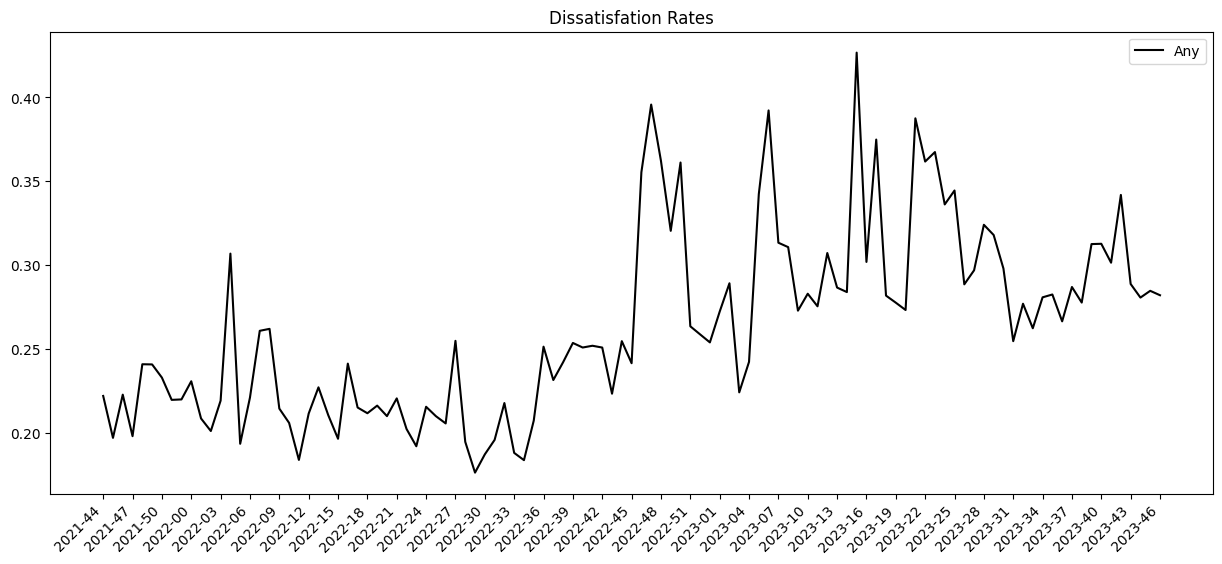

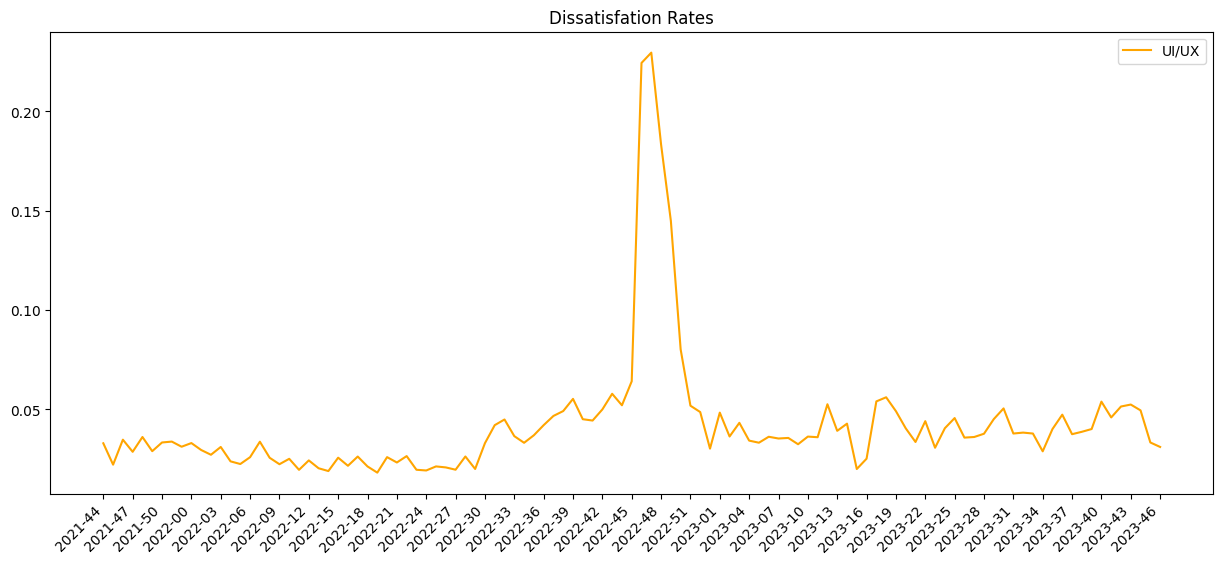

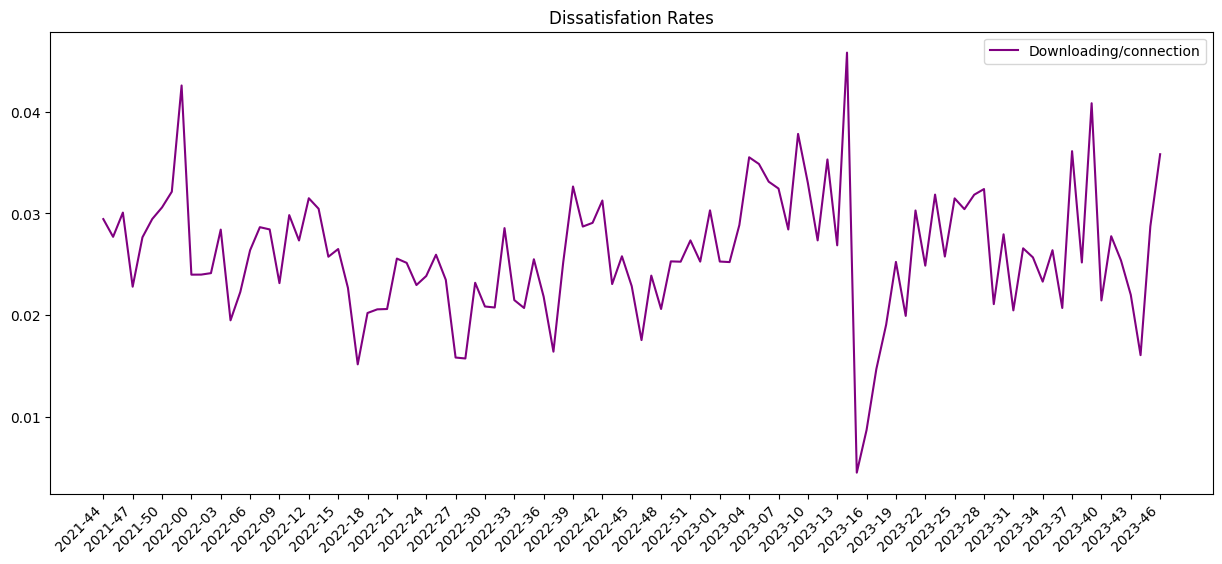

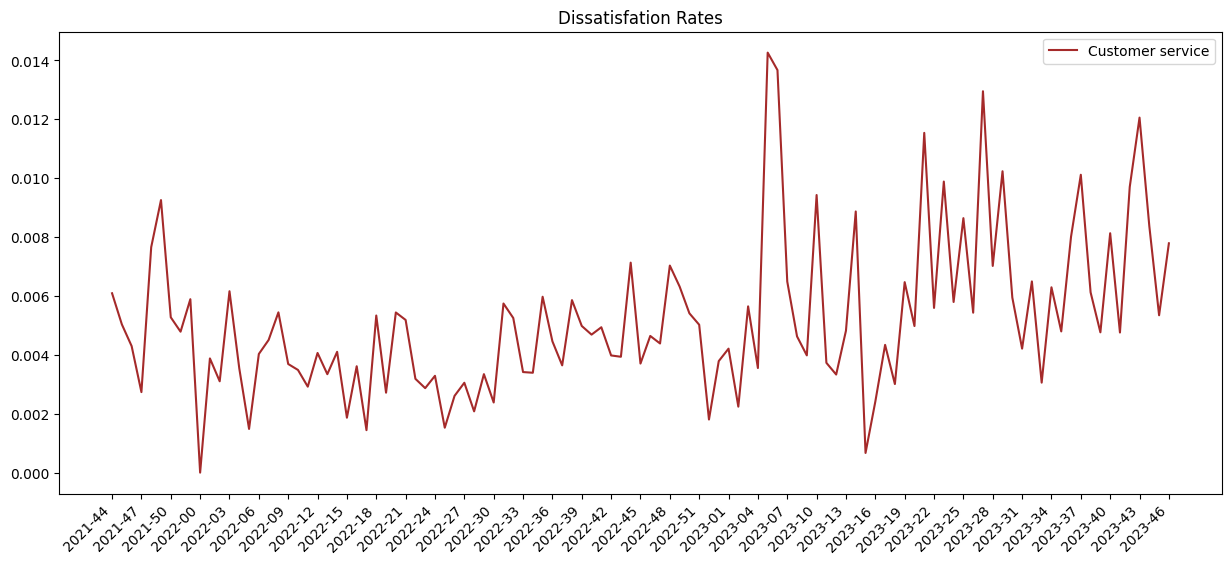

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

#cat = "Total item count"
cats = ["Any","UI/UX", "Content", "Subscription/payment", 'Bugs/stability', "Downloading/connection", "Customer service"]

# Kategori renkleri için bir sözlük oluşturun
category_colors = {
    "Any": "black",
    "UI/UX": "orange",
    "Content": "green",
    "Subscription/payment": "red",
    "Bugs/stability": "blue",
    "Downloading/connection": "purple",
    "Customer service": "brown"
}

# Her kategori için ayrı bir grafik çizin
for cat in cats:
    plt.figure(figsize=(15,6))
    plt.plot(result_matrix[cat], label=cat, color=category_colors[cat])
    plt.legend(loc='upper right')  # Renk legendini ekleyin
    plt.title("Dissatisfation Rates")
    # x ekseni etiketlerini daha anlamlı bir şekilde biçimlendirme
    plt.xticks(result_matrix.index.values[::3],rotation=45, ha='right')

plt.show()

In [ ]:
#@title Review ratings

df_rating = reviews2[-250000:]

list_ = []

# 'timestamp' sütununu gün bazında grupla
grouped_data_rating = df_rating.groupby(pd.to_datetime(df_rating['review_timestamp']).dt.date)

# Her bir gün için normalize et
for day, data_points in grouped_data_rating:

    count = len(data_points)
    total_count += count

    #times_min = data_points['review_timestamp'].min()
    #times_max = data_points['review_timestamp'].max()
    #times_mid = times_min+ (times_max-times_min)/2

    # Normalize et ve güncelle
    rrr = {"Timestamp": day, "Reviews avg": 0}

    total_reviews_count = 0

    # Normalize et ve güncelle
    for index, data_point in data_points.iterrows():
        # Her bir key için normalize edilmiş değeri hesapla ve toplama ekle

        total_reviews_count += data_point["review_rating"]


    rrr["Reviews avg"] = 1-((total_reviews_count / count) - 1)/4

    #normalized_sentiments = {key: value if(key == "Total item count" or key == "Timestamp") else (value / count) for key, value in total_sentiments.items()}

    list_.append(rrr)

result_matrix_reviews = pd.DataFrame(list_)
result_matrix_reviews = result_matrix_reviews.set_axis(result_matrix_reviews["Timestamp"], copy=False)

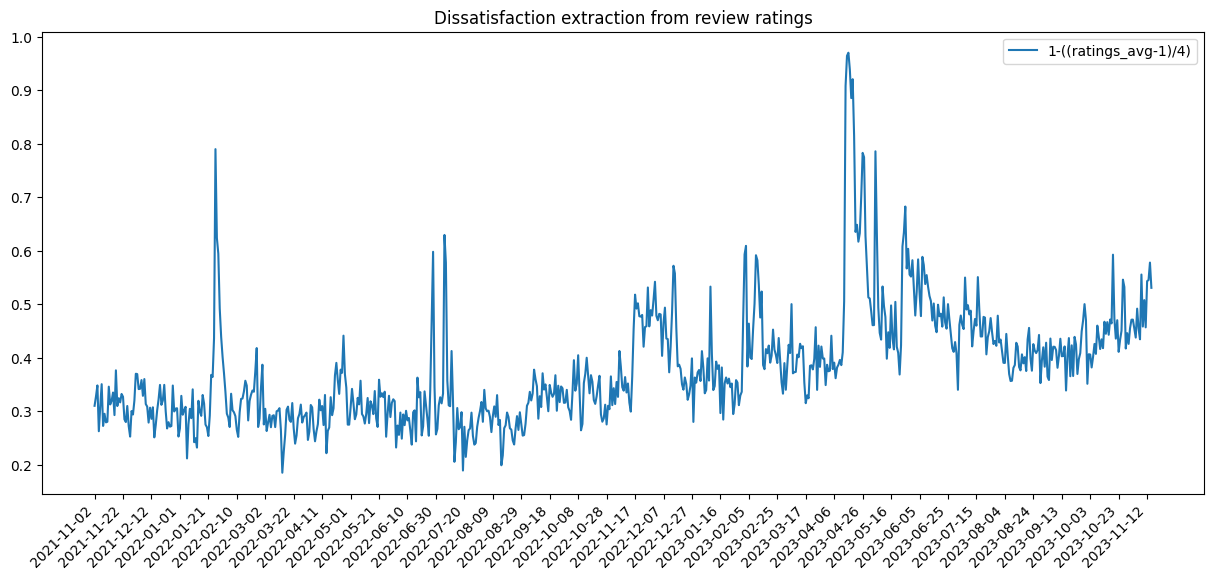

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(15,6))
plt.plot(result_matrix_reviews["Reviews avg"], label="1-((ratings_avg-1)/4)")
plt.legend(loc='upper right')  # Renk legendini ekleyin
plt.title("Dissatisfaction extraction from review ratings")
# x ekseni etiketlerini daha anlamlı bir şekilde biçimlendirme
plt.xticks(result_matrix_reviews.index.values[::20],rotation=45, ha='right')

plt.show()